## Modelo de Índice Único

O retorno de uma ação pode ser escrito como:

$$R_i = \alpha_i + \beta_i R_m + e_i$$

- $R_i$: Retorno do ativo

- $\alpha_i$: Representa o valor esperado do retorno não oriundo do mercado

- $R_m$: Retorno do índice de mercado

- $\beta_i$: mede a mudança esperada em R_i dada uma mudança em R_m

- $e_i$: é o componente aleatório que afeta os retornos.

## CAPM

$$ E(R_i) = R_f + \beta_i (E(R_m) - R_f) $$

- $E(R_i)$: Retorno esperado do ativo.
- $R_f$: Taxa livre de risco (geralmente baseada em títulos do governo).
- $\beta_i$: Coeficiente beta do ativo, que mede seu risco sistemático em relação ao mercado.
- $E(R_m)$: Retorno esperado do mercado.
- $E(R_m) - R_f$: Prêmio de risco de mercado.

## Beta

- Um ativo com $ \beta = 1 $ é considerado tão volátil quanto o mercado. Isso significa que, em média, ele se move na mesma direção e na mesma proporção que o mercado.

- Um ativo com $ \beta > 1 $ é considerado mais volátil que o mercado. Isso significa que, em média, ele tende a ter movimentos maiores do que o mercado.

- Um ativo com $ \beta < 1 $ é considerado menos volátil que o mercado. Isso significa que, em média, ele tende a ter movimentos menores do que o mercado.

- Um ativo com $ \beta = 0 $ é considerado não relacionado ao mercado. Isso significa que seus retornos são independentes dos movimentos do mercado.

# Bibliotecas

In [1]:
!pip install python-bcb

In [24]:
from bcb import sgs
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

## Gráficos
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import matplotlib.pyplot as plt

In [3]:
start = '2014-01-01' # início
end = '2024-05-14' # fim

# CDI

In [5]:
# CDI acumulada no mês (%a.m)
cdi_m = sgs.get({'cdi' : 4391}, start = start)

In [6]:
cdi_m

,cdi
Date,
2014-01-01,0.84
2014-02-01,0.78
2014-03-01,0.76
2014-04-01,0.82
2014-05-01,0.86
...,...
2024-01-01,0.97
2024-02-01,0.80
2024-03-01,0.83


# Retorno do Ibovespa

In [7]:
# Preços Históricos
precos = yf.download('^BVSP', start = start, end = end, interval = '1mo')

# Calcula Retornos Mensais
returns = (
          precos[['Adj Close']]
          .pct_change()
          .rename(columns = {'Adj Close' : 'retornos_ibov'})
          .dropna()
          )

[*********************100%%**********************]  1 of 1 completed


In [8]:
returns

,retornos_ibov
Date,
2014-02-01,-0.011440
2014-03-01,0.070519
2014-04-01,0.024021
2014-05-01,-0.007496
2014-06-01,0.037647
...,...
2024-01-01,-0.047941
2024-02-01,0.009925
2024-03-01,-0.007084


In [9]:
# Junta os data frames
returns_rf =  (
    returns.merge(cdi_m, left_index = True, right_index = True)
    .assign(cdi = lambda x: x.cdi / 100)
    )

In [10]:
returns_rf

,retornos_ibov,cdi
Date,,
2014-02-01,-0.011440,0.0078
2014-03-01,0.070519,0.0076
2014-04-01,0.024021,0.0082
2014-05-01,-0.007496,0.0086
2014-06-01,0.037647,0.0082
...,...,...
2024-01-01,-0.047941,0.0097
2024-02-01,0.009925,0.0080
2024-03-01,-0.007084,0.0083


# Ativo

In [11]:
# Tickers dos ativos
assets = ['BBDC4.SA', 'ITSA4.SA', 'VALE3.SA', 'WEGE3.SA']

# Baixa os dados (dados mensais)
precos_ativos = yf.download(assets, start = start, end = end, interval = '1mo')
precos_ativos = precos_ativos.loc[:,('Adj Close', slice(None))]
precos_ativos.columns = assets

# Calculando os retornos
Y = precos_ativos[assets].pct_change().dropna()

# Verifica os retornos
Y.head()

[*********************100%%**********************]  4 of 4 completed


,BBDC4.SA,ITSA4.SA,VALE3.SA,WEGE3.SA
Date,,,,
2014-02-01,0.043960,0.009941,-0.001513,0.116424
2014-03-01,0.152413,0.092090,-0.047879,0.045728
2014-04-01,0.065903,0.059173,-0.059516,0.106488
2014-05-01,-0.059888,-0.038343,-0.009714,-0.033445
2014-06-01,0.027543,0.016374,0.027407,0.087659


In [12]:
# Número de ativos
num_ativos = len(Y.columns)

# Calcula pesos iguais
peso_por_ativo = 1.0 / num_ativos
ewp = [peso_por_ativo] * num_ativos

# Pesos
ewp

[0.25, 0.25, 0.25, 0.25]

In [13]:
# Calcula o retorno do portfólio
portfolio_returns_ewp = pd.DataFrame((Y * ewp).sum(axis = 1), columns = ['portfolio_ewp'])
portfolio_returns_ewp

,portfolio_ewp
Date,
2014-02-01,0.042203
2014-03-01,0.060588
2014-04-01,0.043012
2014-05-01,-0.035347
2014-06-01,0.039746
...,...
2024-01-01,-0.086114
2024-02-01,0.012482
2024-03-01,0.011251


In [14]:
# Junta os dados
portfolio = (
            portfolio_returns_ewp
            .merge(returns_rf, left_index = True, right_index = True)
            )

portfolio.head()

,portfolio_ewp,retornos_ibov,cdi
Date,,,
2014-02-01,0.042203,-0.011440,0.0078
2014-03-01,0.060588,0.070519,0.0076
2014-04-01,0.043012,0.024021,0.0082
2014-05-01,-0.035347,-0.007496,0.0086
2014-06-01,0.039746,0.037647,0.0082


# Excesso de Retorno

In [15]:
# Calcula o excesso de retorno do portfólio
portfolio['excesso_retorno'] = portfolio['portfolio_ewp'] - portfolio['cdi']

# Calcula o excesso de retorno do mercado
portfolio['excesso_ibovespa'] = portfolio['retornos_ibov'] - portfolio['cdi']

portfolio.head()

,portfolio_ewp,retornos_ibov,cdi,excesso_retorno,excesso_ibovespa
Date,,,,,
2014-02-01,0.042203,-0.011440,0.0078,0.034403,-0.019240
2014-03-01,0.060588,0.070519,0.0076,0.052988,0.062919
2014-04-01,0.043012,0.024021,0.0082,0.034812,0.015821
2014-05-01,-0.035347,-0.007496,0.0086,-0.043947,-0.016096
2014-06-01,0.039746,0.037647,0.0082,0.031546,0.029447


# Regressão Linear

In [16]:
# Cria um modelo de regressão linear via MQO
model_fit = (smf.ols(
    formula = "excesso_retorno ~ excesso_ibovespa", # fórmula
    data = portfolio) # dados
  .fit() # realiza o ajuste
)

# Verifica o resultado do modelo
model_fit_coefs = model_fit.summary(slim = True).tables[1]
print(model_fit_coefs)

                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0065      0.003      2.511      0.013       0.001       0.012
excesso_ibovespa     0.9166      0.039     23.241      0.000       0.839       0.995


# Gráfico de Dispersão

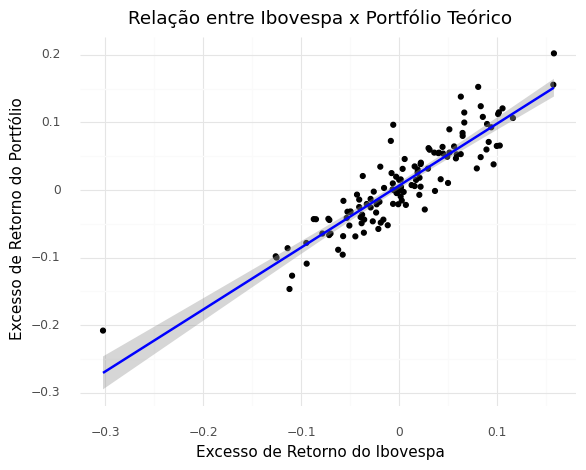

<ggplot: (147507847677)>

In [18]:
# Cria um gráfico de dispersão com reta de regressão
(ggplot(portfolio, aes(x = 'excesso_ibovespa', y = 'excesso_retorno'))
 + geom_point()
 + stat_smooth(method = 'lm', color = 'blue')
 + labs(title = 'Relação entre Ibovespa x Portfólio Teórico', x = 'Excesso de Retorno do Ibovespa', y = 'Excesso de Retorno do Portfólio')
 + theme_minimal())

# Beta Móvel

In [19]:
# Cria função para estimar o beta móvel
def roll_capm_estimation(data, window_size, min_obs):

    result = (RollingOLS.from_formula(
      formula = "excesso_retorno ~ excesso_ibovespa",
      data = data,
      window = window_size,
      min_nobs = min_obs
      )
      .fit()
      .params["excesso_ibovespa"]
    )

    result.index = data.index
    result = pd.DataFrame(result).rename({'excesso_ibovespa' : 'beta'}, axis = 1)
    return result

In [20]:
# Estima o beta móvel em janelas de 60 meses
beta = roll_capm_estimation(data = portfolio, window_size = 60, min_obs = 48)

In [21]:
# Realiza tratamento sobre o data frame
beta.reset_index(inplace = True)
beta.dropna(inplace = True)

beta

,Date,beta
59,2019-01-01,1.005189
60,2019-02-01,1.012004
61,2019-03-01,1.015656
62,2019-04-01,1.014990
63,2019-05-01,1.012012
...,...,...
119,2024-01-01,0.843708
120,2024-02-01,0.842044
121,2024-03-01,0.841701
122,2024-04-01,0.840603


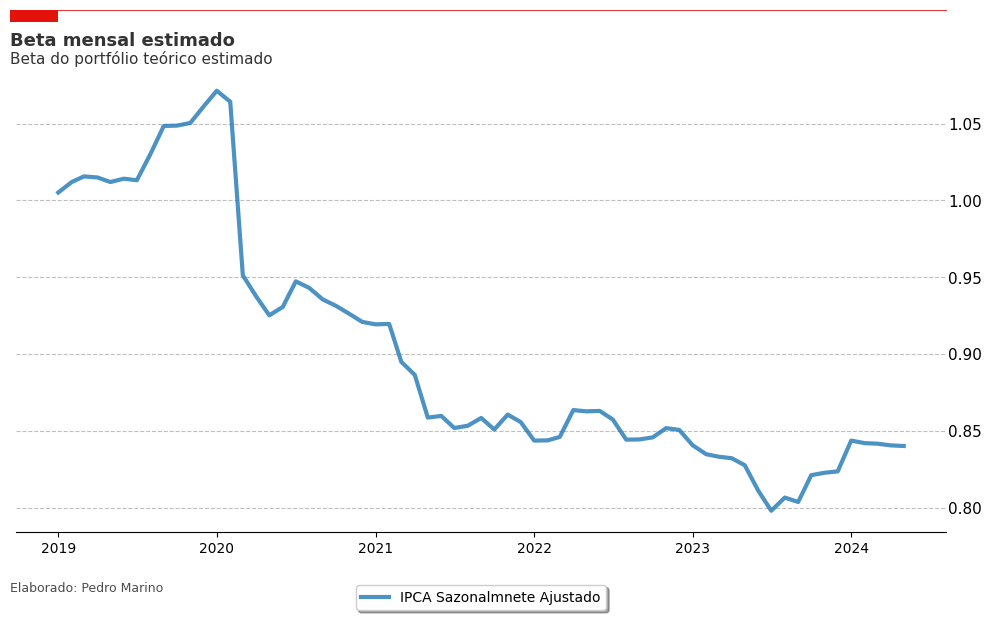

In [28]:
# Setup plot size.
fig, ax = plt.subplots(figsize=(12, 6))

# Loop through country names and plot each one with a different color.
ax.plot(beta["Date"],
        beta["beta"],
        alpha=0.8,
        linewidth=3,
        label= "IPCA Sazonalmnete Ajustado")  # Add label for legend

# Add legend below the plot.
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True)

######### Estética do Gráfico #########
# Remove splines. Can be done one at a time or can slice with a list.
ax.spines[['top', 'right', 'left']].set_visible(False)


ax.yaxis.grid(True, linestyle='--', which='major', color='gray', alpha=0.5)  # Add grid lines for y-axis

ax.yaxis.set_tick_params(pad=-2, labeltop=True, labelbottom=False, bottom=False, labelsize=11)

# Add in line and tag
ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#E3120B', linewidth=.6)
ax.add_patch(plt.Rectangle((0.12, .98), 0.04, -0.02, facecolor='#E3120B', transform=fig.transFigure, clip_on=False, linewidth=0))

# Add in title and subtitle
ax.text(x=0.12, y=.92, s="Beta mensal estimado", transform=fig.transFigure, ha='left', fontsize=13, weight='bold', alpha=.8)
ax.text(x=0.12, y=.89, s="Beta do portfólio teórico estimado", transform=fig.transFigure, ha='left', fontsize=11, alpha=.8)

# Set source text
ax.text(x=0.12, y=0.01, s="""Elaborado: Pedro Marino""", transform=fig.transFigure, ha='left', fontsize=9, alpha=.7)

plt.show()